In [1]:

import numpy as np
import anndata
import scanpy as sc
import igraph
import ALLCools
from ALLCools.integration.seurat_class import SeuratIntegration
import scanpy._utils as sc_utils 
import networkx as nx
import metis
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import os
from scipy.stats import zscore
import seaborn as sns 

In [2]:
import numpy as np
import anndata
import scanpy as sc
import pandas as pd

In [3]:
DR2_2= sc.read_h5ad('/mnt/f/spatial/DR2_2.h5ad')

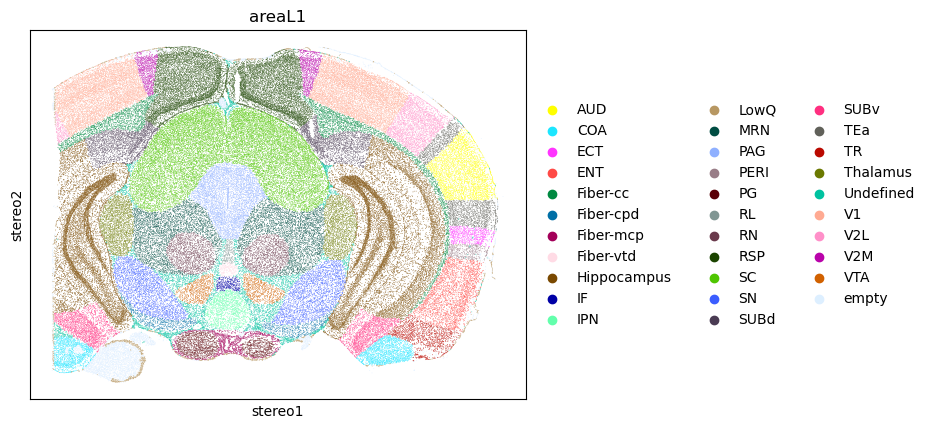

In [4]:
sc.pl.embedding(DR2_2, basis='stereo',color='areaL1')

In [5]:
DR2_2_V2L = DR2_2[DR2_2.obs['areaL1']=='V2L']

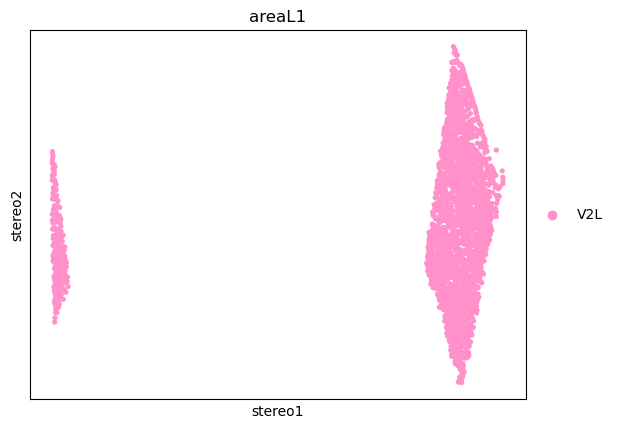

In [6]:
sc.pl.embedding(DR2_2_V2L, basis='stereo',color='areaL1')

In [7]:
DR2_2_V2LR = DR2_2_V2L[DR2_2_V2L.obs['left_right']=='right']

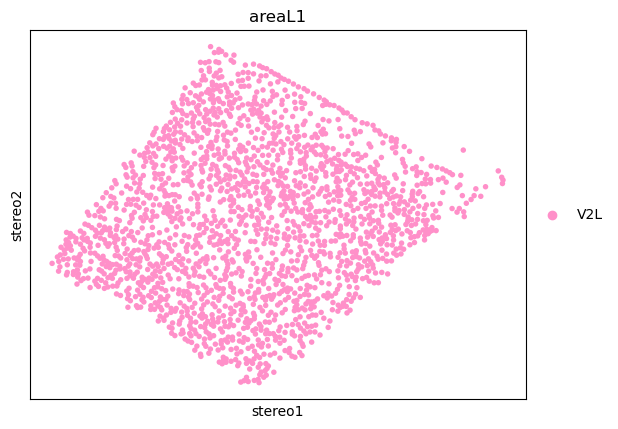

In [8]:
sc.pl.embedding(DR2_2_V2LR, basis='stereo',color='areaL1')

In [9]:
D_V2L_Sn = sc.read_h5ad('/mnt/g/single cell data/RNA_velocity/V2L/DR_V2L_ann_filter.h5ad')

In [10]:
D_V2L_Sn

AnnData object with n_obs × n_vars = 16909 × 21834
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'dendrogram_leiden_res_1.50', 'hvg', 'leiden_res_1.50', 'leiden_res_1.50_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
# Consider the common genes
common_genes = np.array(D_V2L_Sn.var_names.intersection(DR2_2_V2LR.var_names))

In [12]:
def get_sparse_from_igraph(graph, weight_attr=None):
    from scipy.sparse import csr_matrix

    edges = graph.get_edgelist()
    if weight_attr is None:
        weights = [1] * len(edges)
    else:
        weights = graph.es[weight_attr]
    if not graph.is_directed():
        edges.extend([(v, u) for u, v in edges])
        weights.extend(weights)
    shape = graph.vcount()
    shape = (shape, shape)
    if len(edges) > 0:
        return csr_matrix((weights, zip(*edges)), shape=shape)
    else:
        return csr_matrix(shape)

In [13]:
def partition_subclasses(adata, n_partitions):
    '''Assign integration partitions as the adata.obs['integration_partion'] column.'''
    adata.obs['integration_partition'] = 'p0'
    
    # Get a sparse matrix of that counts edges between subclasses
    ones = adata.obsp['distances'].copy()
    ones.data = np.ones(len(ones.data))

    g_neighobrs = sc._utils.get_igraph_from_adjacency(ones, directed=True)
    vc = igraph.VertexClustering(g_neighobrs, membership=adata.obs['Subclass'].cat.codes.values)
    cluster_mtx = get_sparse_from_igraph(vc.cluster_graph(combine_edges='sum'), weight_attr='weight')
    
    # Partition the cluster level graph
    G_cluster = nx.from_scipy_sparse_array(cluster_mtx)
    for i in adata.obs['Subclass'].cat.codes.values:
        G_cluster.nodes[i]['weight'] = np.sum(adata.obs['Subclass'] 
                                              == adata.obs['Subclass'].cat.categories[i] )
    G_cluster.graph['node_weight_attr'] = 'weight'
    
    (cut, parts) = metis.part_graph(G_cluster, n_partitions, recursive=False,
                                   tpwgts=[1 / n_partitions] * n_partitions) 
    
    # Assign the partitions
    for i in range(len(parts)):
        mask = (adata.obs['Subclass'] == adata.obs['Subclass'].cat.categories[i])
        adata.obs.loc[mask, 'integration_partition'] = 'p' + str(parts[i])
    
    adata.obs['integration_partition'] = adata.obs['integration_partition'].astype('category')
    
import scipy.sparse
def get_cluster_mean_expression_matrix(adata, cluster_column):
    '''Get a dataframe of mean gene expression of each cluster.'''
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
   
    cell_exp_mtx = pd.DataFrame(X, index=adata.obs[cluster_column], columns=adata.var.index)    
    return cell_exp_mtx.groupby(by=cluster_column).mean()

def calculate_correlation_matrix(adata, cluster_column):
    '''Calculate gene expression correlations between clusters.'''
    cluster_mean_exp = get_cluster_mean_expression_matrix(adata, cluster_column)
    
    # Initialzie the correlation matrix
    cluster_ids = np.array(cluster_mean_exp.index)
    N_clusters = len(cluster_ids)
    correlation_mtx = pd.DataFrame(np.ones((N_clusters, N_clusters)), index=cluster_ids, columns=cluster_ids)
    
    # Fill the correlation matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        mean_exps1 = np.array(cluster_mean_exp.loc[cluster_id1])
        
        for j in range(i + 1, N_clusters):
            cluster_id2 = cluster_ids[j]
            mean_exps2 = np.array(cluster_mean_exp.loc[cluster_id2])
            
            r, p = scipy.stats.pearsonr(mean_exps1, mean_exps2)

            correlation_mtx.loc[cluster_id1, cluster_id2] = r
            correlation_mtx.loc[cluster_id2, cluster_id1] = r
            
    return correlation_mtx

def merge_clusters(obs_df, cluster_col, clusters_to_merge):
    merged_cluster_id = sorted(clusters_to_merge)[0]
    obs_df[cluster_col][obs_df[cluster_col].isin(clusters_to_merge)] = merged_cluster_id
    obs_df[cluster_col] = obs_df[cluster_col].cat.remove_unused_categories()

In [15]:
%%time
# Define the integration partitions using the sequencing data
n_partitions = 100

# 标准化并检查数据
sc.pp.normalize_total(D_V2L_Sn, target_sum=1000)


# 对数转换并检查数据
sc.pp.log1p(D_V2L_Sn)


# 缩放并防止除以零的情况
sc.pp.scale(D_V2L_Sn, zero_center=False)


# PCA降维
n_pcs = 100
sc.tl.pca(D_V2L_Sn, svd_solver='arpack', n_comps=n_pcs)


# 计算neighbors
sc.pp.neighbors(D_V2L_Sn, use_rep='X_pca', n_neighbors=25, n_pcs=n_pcs)

# 分区并进行整合
partition_subclasses(D_V2L_Sn, n_partitions)

# 后续的分区合并和处理
partition_corr_df = calculate_correlation_matrix(D_V2L_Sn, 'integration_partition')
p_names, p_n_cells = np.unique(D_V2L_Sn.obs['integration_partition'], return_counts=True)
p_smalls = p_names[p_n_cells < 10000]
p_larges = p_names[p_n_cells >= 10000]
partition_corr_df = partition_corr_df.loc[p_smalls, p_larges]

for p1 in p_smalls:
    # 检查 partition_corr_df.loc[p1] 是否为空
    if partition_corr_df.loc[p1].empty:
        print(f"Warning: partition {p1} has no corresponding large partition.")
        continue  # 跳过这个空的序列
    
    # 继续进行合并
    p2 = partition_corr_df.columns[np.argmax(partition_corr_df.loc[p1])]
    print(f'Merge partitions {p1} and {p2}')
    merge_clusters(D_V2L_Sn.obs, 'integration_partition', [p1, p2])

seq_annotation_df = D_V2L_Sn.obs.copy()


/tmp/ipykernel_214283/4169816286.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return cell_exp_mtx.groupby(by=cluster_column).mean()


CPU times: user 57.7 s, sys: 2.59 s, total: 1min
Wall time: 10.9 s


In [16]:
%%time
# Reload the sequencing data and assign the partitions
D_V2L_Sn.obs['integration_partition'] = seq_annotation_df['integration_partition']

D_V2L_Sn.obs['Subclass'] = D_V2L_Sn.obs['Subclass'].astype('category')
D_V2L_Sn.obs['Type'] = D_V2L_Sn.obs['Type'].astype('category')

D_V2L_Sn = D_V2L_Sn[~D_V2L_Sn.obs['Type'].isna()]
D_V2L_Sn = D_V2L_Sn[~D_V2L_Sn.obs['Subclass'].isna()]

CPU times: user 52 ms, sys: 100 ms, total: 152 ms
Wall time: 150 ms


In [17]:
%%time
# Split the sequencing data for the input of the final round of integration.
# Because imputation is done at this round, all genes are included.

partition_path = '/mnt/f/spatial/V2L/DR2_2/partitions/'

# 获取分区信息
partitions = D_V2L_Sn.obs['integration_partition'].cat.categories

print('Partition, N_cells, subclasses')

# 遍历每个分区
for pn in partitions:
    # 根据分区选择子集数据
    adata_subset = D_V2L_Sn[D_V2L_Sn.obs['integration_partition'] == pn]
    
    # 替换路径中的不合法字符并生成保存路径
    partition_save_path = partition_path + pn.replace('/', '-').replace(' ', '_') + '/'
    
    # 自动创建目标文件夹，如果不存在则创建
    os.makedirs(partition_save_path, exist_ok=True)
    
    # 将子集数据保存到 .h5ad 文件
    save_file = partition_save_path + 'adata_seq.h5ad'
    adata_subset.write_h5ad(save_file, compression='gzip')
    
    # 打印分区的统计信息
    print(f'{pn}, {adata_subset.shape[0]}, {list(np.unique(adata_subset.obs["Subclass"]))}')


Partition, N_cells, subclasses
p24, 4067, ['L2/3 IT CTX']
p30, 628, ['L5 ET CTX']
p36, 724, ['Astro']
p49, 3021, ['L4/5 IT CTX']
p55, 710, ['Pvalb']
p58, 705, ['Microglia']
p61, 234, ['L5 NP CTX']
p63, 493, ['Sst']
p64, 156, ['L6b CTX']
p67, 382, ['Lamp5']
p70, 472, ['OPC']
p72, 383, ['Vip']
p73, 109, ['ABC', 'Sncg', 'VLMC']
p74, 377, ['L5 IT CTX']
p86, 2027, ['Oligo']
p92, 1652, ['L6 CT CTX']
p99, 769, ['L6 IT CTX']
CPU times: user 15.1 s, sys: 224 ms, total: 15.3 s
Wall time: 24.4 s


In [18]:
# Merge the datasets
DR_V2L_merge = D_V2L_Sn.concatenate(DR2_2_V2LR,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None,join='outer')

/tmp/ipykernel_214283/877262132.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  DR_V2L_merge = D_V2L_Sn.concatenate(DR2_2_V2LR,
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [19]:
%%time
# Get the significant PCs
n_pcs = 20
sc.tl.pca(DR_V2L_merge, svd_solver='arpack', n_comps=n_pcs)

CPU times: user 51.6 s, sys: 573 ms, total: 52.2 s
Wall time: 4.58 s


In [20]:
DR_V2L_list = [DR_V2L_merge[DR_V2L_merge.obs['modality'] == 'seq'],
              DR_V2L_merge[DR_V2L_merge.obs['modality'] == 'spatial']]

In [21]:
%%time
# Find the integration anchors
integrator = SeuratIntegration()
integrator.find_anchor(DR_V2L_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=50,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None,
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])

Find anchors across datasets.
Run CCA
non zero dims 20
Find Anchors using k=100
Score Anchors
Identified 93139 anchors between datasets 0 and 1.
CPU times: user 1min 40s, sys: 21.9 s, total: 2min 2s
Wall time: 20.5 s


In [22]:
#label transfer
cell_type_col = 'integration_partition'

transfer_results = integrator.label_transfer(
    ref=[0],
    qry=[1],
    categorical_key=[cell_type_col],
    key_dist='X_pca',
    k_weight=100,
    npc=n_pcs)

integrator.save_transfer_results_to_adata(DR_V2L_merge, transfer_results)

Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer


In [23]:
# Assign the transfered labels and the confidence
DR2_2_V2LR.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1).astype('category')
DR2_2_V2LR.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)

n_transfered = len(np.unique(DR2_2_V2LR.obs[cell_type_col + '_transfer']))
n_total = len(np.unique(DR_V2L_merge.obs[cell_type_col + '_transfer']))
print(f'Transfered {n_transfered}/{n_total} cell types.')

Transfered 17/17 cell types.


/tmp/ipykernel_214283/2388490487.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  DR2_2_V2LR.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1).astype('category')


In [24]:
# Save the label transfer results for each class
partition_path = '/mnt/f/spatial/V2L/DR2_2/partitions/'


partitions = DR2_2_V2LR.obs[cell_type_col + '_transfer'].unique()

cell_type_col = 'integration_partition'

for pn in partitions:

    adata_subset =DR2_2_V2LR[DR2_2_V2LR.obs[cell_type_col + '_transfer'] == pn]
    

    partition_save_path = partition_path + pn.replace('/', '-').replace(' ', '_') + '/'
    

    if not os.path.exists(partition_save_path):
        os.makedirs(partition_save_path, exist_ok=True)
    

    save_file = partition_save_path + 'adata_spatial_integrated.h5ad'
    

    adata_subset.write_h5ad(save_file, compression='gzip')
    

    print(f'Successfully saved for partition {pn} at: {save_file}')

Successfully saved for partition p73 at: /mnt/f/spatial/V2L/DR2_2/partitions/p73/adata_spatial_integrated.h5ad
Successfully saved for partition p58 at: /mnt/f/spatial/V2L/DR2_2/partitions/p58/adata_spatial_integrated.h5ad
Successfully saved for partition p24 at: /mnt/f/spatial/V2L/DR2_2/partitions/p24/adata_spatial_integrated.h5ad
Successfully saved for partition p86 at: /mnt/f/spatial/V2L/DR2_2/partitions/p86/adata_spatial_integrated.h5ad
Successfully saved for partition p36 at: /mnt/f/spatial/V2L/DR2_2/partitions/p36/adata_spatial_integrated.h5ad
Successfully saved for partition p67 at: /mnt/f/spatial/V2L/DR2_2/partitions/p67/adata_spatial_integrated.h5ad
Successfully saved for partition p55 at: /mnt/f/spatial/V2L/DR2_2/partitions/p55/adata_spatial_integrated.h5ad
Successfully saved for partition p70 at: /mnt/f/spatial/V2L/DR2_2/partitions/p70/adata_spatial_integrated.h5ad
Successfully saved for partition p49 at: /mnt/f/spatial/V2L/DR2_2/partitions/p49/adata_spatial_integrated.h5ad
S

In [25]:
%%time
# Correct the PCs using the integration anchors
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

DR_V2L_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)

Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data
CPU times: user 5min 26s, sys: 39.6 s, total: 6min 5s
Wall time: 53.3 s


In [26]:
# Calculate KNN using the integrated PCs
sc.pp.neighbors(DR_V2L_merge,use_rep='X_pca_integrate')

In [54]:
Partition, N_cells, subclasses
p11, 724, ['Astro']
p24, 3021, ['L4/5 IT CTX']
p49, 4067, ['L2/3 IT CTX']
p5, 234, ['L5 NP CTX']
p51, 206, ['ABC', 'L6b CTX', 'VLMC']
p52, 377, ['L5 IT CTX']
p55, 628, ['L5 ET CTX']
p58, 493, ['Sst']
p60, 59, ['Sncg']
p61, 383, ['Vip']
p67, 710, ['Pvalb']
p70, 705, ['Microglia']
p72, 382, ['Lamp5']
p74, 472, ['OPC']
p86, 2027, ['Oligo']
p92, 1652, ['L6 CT CTX']
p99, 769, ['L6 IT CTX']
CPU times: user 15.5 s, sys: 245 ms, total: 15.7 s
Wall time: 25.1 s

NameError: name 'p100' is not defined

In [27]:
subclass_dict={'p92':'L6 CT CTX',
'p70':'OPC',
'p30' :'L5 ET CTX',
'p74' :'L5 IT CTX',
'p99' :'L6 IT CTX',
'p72' :'Vip',
'p67' :'Lamp5',
'p61' :'L5 NP CTX',
'p58' :'Microglia',
'p64' :'L6b CTX',
'p73' :'ABC_Sncg_VLMC',
'p63' :'Sst',
'p36' :'Astro',
'p24'  :'L2/3 IT CTX',
'p49'  :'L4/5 IT CTX',
'p86'  :'Oligo'}

In [28]:
DR_V2L_merge.obs['integration_subclass_transfer'] = DR_V2L_merge.obs['integration_partition_transfer'].map(subclass_dict)
print(DR_V2L_merge.obs[['integration_partition_transfer', 'integration_subclass_transfer']])

                         integration_partition_transfer  \
AAACCCAAGAGGTGCT-1-V2L_1                            p99   
AAACCCAAGATGACAT-1-V2L_1                            p92   
AAACCCAAGGGTTTCT-1-V2L_1                            p36   
AAACCCAAGTATAACG-1-V2L_1                            p61   
AAACCCAAGTTCAACC-1-V2L_1                            p86   
...                                                 ...   
17887                                               p92   
17890                                               p92   
17894                                               p99   
17904                                               p92   
17908                                               p74   

                         integration_subclass_transfer  
AAACCCAAGAGGTGCT-1-V2L_1                     L6 IT CTX  
AAACCCAAGATGACAT-1-V2L_1                     L6 CT CTX  
AAACCCAAGGGTTTCT-1-V2L_1                         Astro  
AAACCCAAGTATAACG-1-V2L_1                     L5 NP CTX  
AAACCC

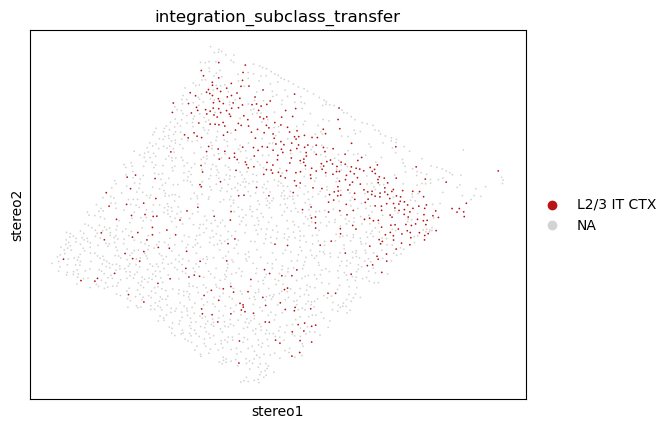

View of AnnData object with n_obs × n_vars = 464 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

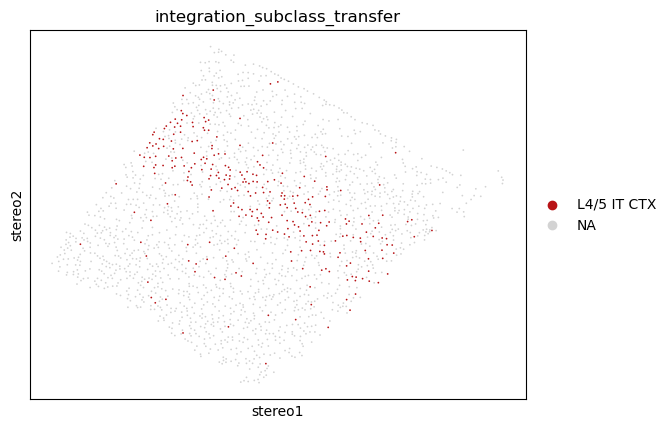

View of AnnData object with n_obs × n_vars = 294 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

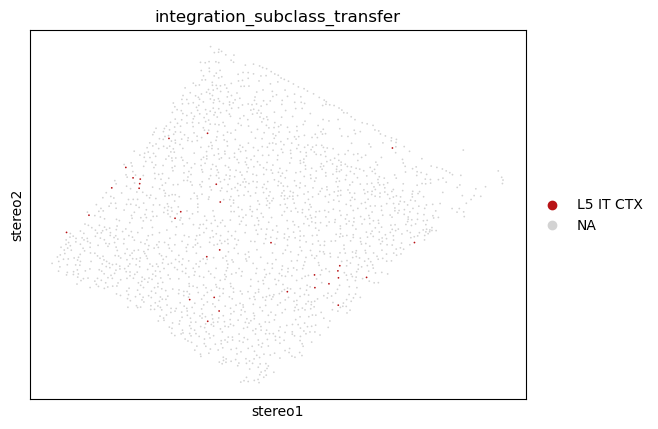

View of AnnData object with n_obs × n_vars = 32 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

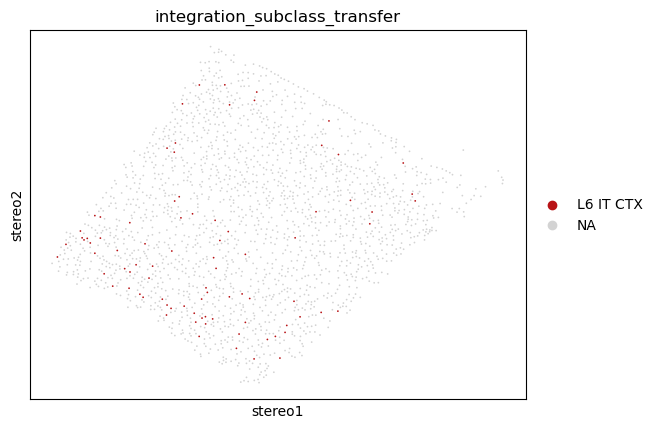

View of AnnData object with n_obs × n_vars = 86 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

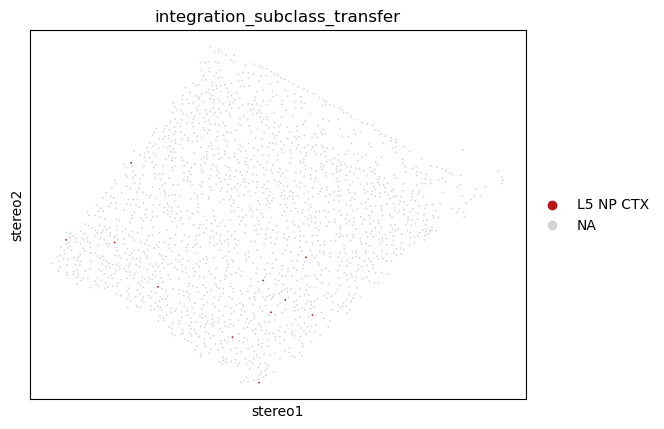

View of AnnData object with n_obs × n_vars = 11 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

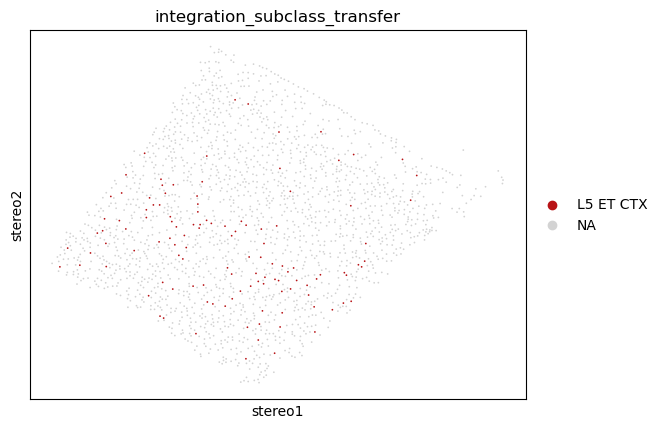

View of AnnData object with n_obs × n_vars = 119 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

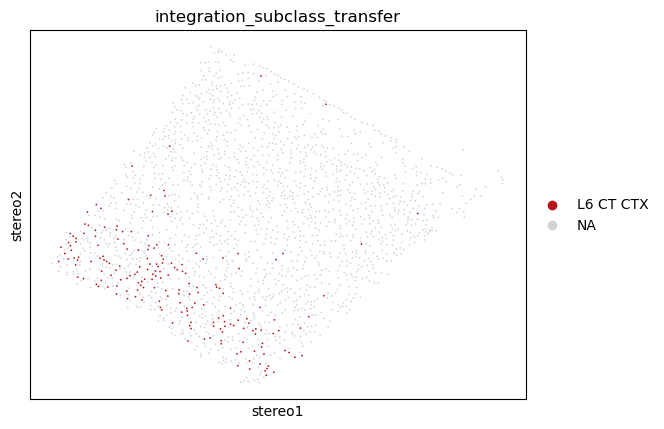

View of AnnData object with n_obs × n_vars = 193 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

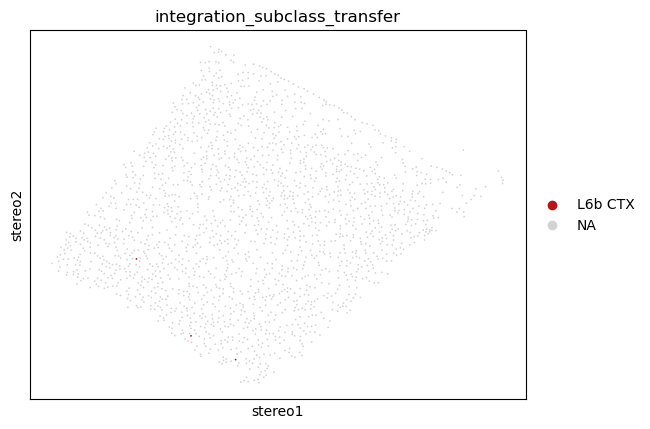

View of AnnData object with n_obs × n_vars = 3 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'


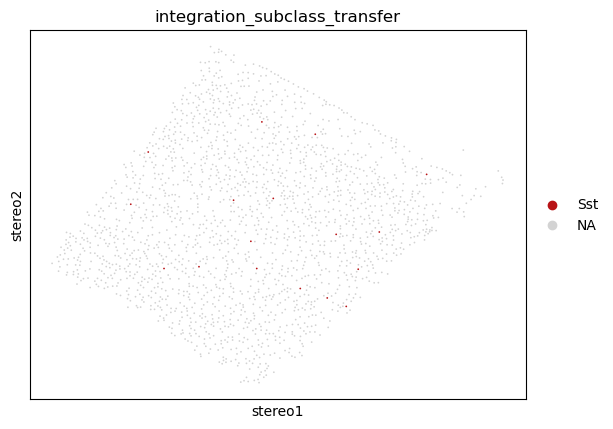

View of AnnData object with n_obs × n_vars = 17 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

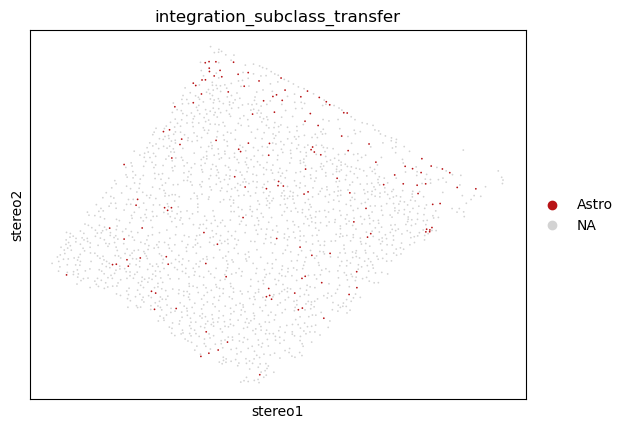

View of AnnData object with n_obs × n_vars = 145 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

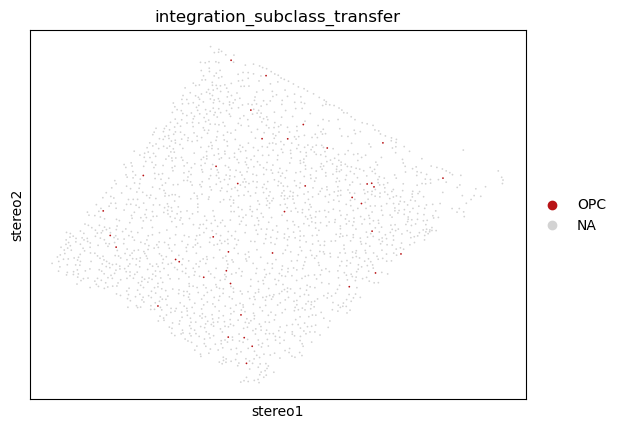

View of AnnData object with n_obs × n_vars = 40 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

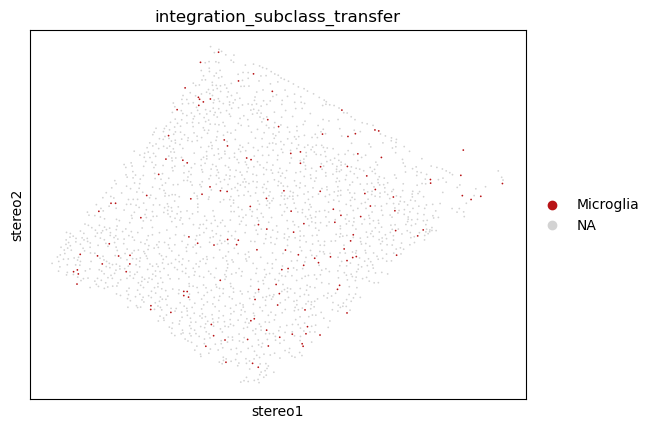

View of AnnData object with n_obs × n_vars = 146 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

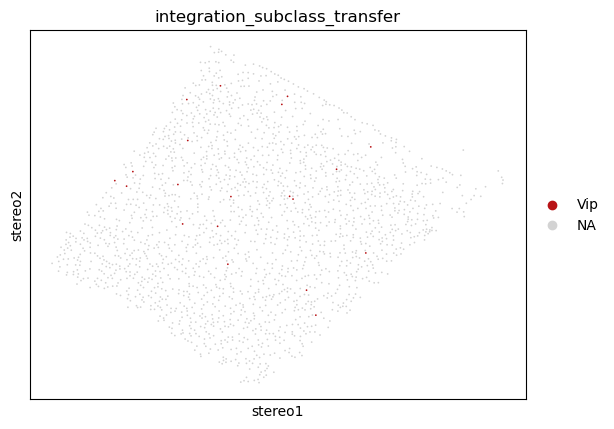

View of AnnData object with n_obs × n_vars = 20 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

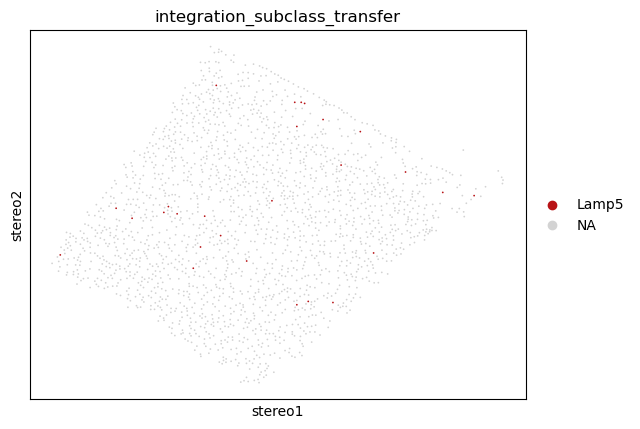

View of AnnData object with n_obs × n_vars = 27 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts'

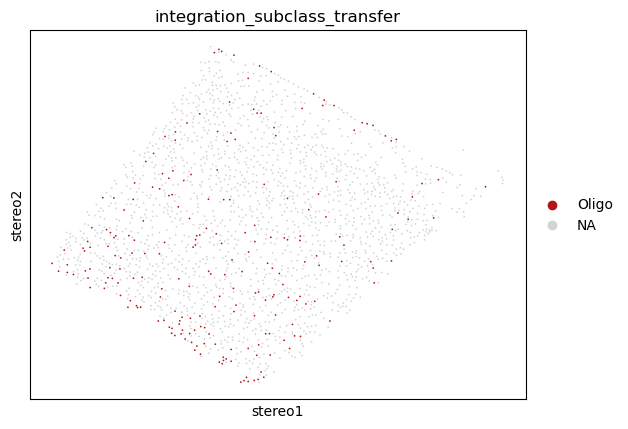

View of AnnData object with n_obs × n_vars = 224 × 26259
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type', 'integration_partition', 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'modality', 'integration_partition_transfer', 'integration_subclass_transfer'
    var: 'gene_ids-seq', 'feature_types-seq', 'n_cells-V2L_1-seq', 'highly_variable-V2L_1-seq', 'means-V2L_1-seq', 'dispersions-V2L_1-seq', 'dispersions_norm-V2L_1-seq', 'n_cells-V2L_2-seq', 'highly_variable-V2L_2-seq', 'means-V2L_2-seq', 'dispersions-V2L_2-seq', 'dispersions_norm-V2L_2-seq', 'highly_variable-seq', 'means-seq', 'dispersions-seq', 'dispersions_norm-seq', 'mean-seq', 'std-seq', 'gene-spatial'
    uns: 'pca', 'neighbors', 'integration_subclass_transfer_colors'
    obsm: 'X_pca', 'X_umap', 'stereo', 'X_pca_integrate'
    varm: 'PCs'
    layers: 'counts

In [29]:
DR_V2L_spatial = DR_V2L_merge[DR_V2L_merge.obs['modality']=='spatial']

sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L2/3 IT CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L2/3 IT CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L4/5 IT CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L4/5 IT CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 IT CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L5 IT CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6 IT CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L6 IT CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 NP CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L5 NP CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L5 ET CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L5 ET CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6 CT CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L6 CT CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['L6b CTX'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='L6b CTX'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Sst'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Sst'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Astro'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Astro'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['OPC'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='OPC'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Microglia'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Microglia'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Vip'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Vip'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Lamp5'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Lamp5'])
sc.pl.embedding(DR_V2L_merge,basis='stereo',color=['integration_subclass_transfer'],groups=['Oligo'],palette=["#b81316"])
print(DR_V2L_spatial[DR_V2L_spatial.obs['integration_subclass_transfer']=='Oligo'])

In [30]:
coembedding_umap_df = DR_V2L_merge.obs[[]].copy()
coembedding_umap_df['umap_x'] = DR_V2L_merge.obsm['X_umap'][:, 0]
coembedding_umap_df['umap_y'] = DR_V2L_merge.obsm['X_umap'][:, 1]
coembedding_umap_df.to_csv('coembedding_umap.csv')

In [ ]:
#Integrate individual partitions

In [31]:
def impute_gene_expression(integrator, adata_list, X_ref, ref=0, qry=1, npc=30, k_weight=30, sd=1,
                           chunk_size=1000, random_state=0):
    data_qry = adata_list[qry].obsm['X_pca']

    anchor, G, D, cum_qry = integrator.find_nearest_anchor(adata_list, data_qry=data_qry, ref=[ref], qry=[qry],
                                                      npc=npc, k_weight=k_weight, sd=sd, random_state=random_state)
    
    if scipy.sparse.issparse(X_ref):
        X_ref = X_ref.toarray()
    
    X_anchor = X_ref[anchor[:, 0]]
    imputed_chunks = []
    
    for chunk_start in np.arange(0, data_qry.shape[0], chunk_size):
        imputed_chunks.append(scipy.sparse.csr_matrix((
                        D[chunk_start:(chunk_start + chunk_size), :, None] *
                        X_anchor[G[chunk_start:(chunk_start + chunk_size)]]
                    ).sum(axis=1).astype(np.float32)))

    return scipy.sparse.vstack(imputed_chunks)

Integrating for partition p24


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 11598 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 464 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


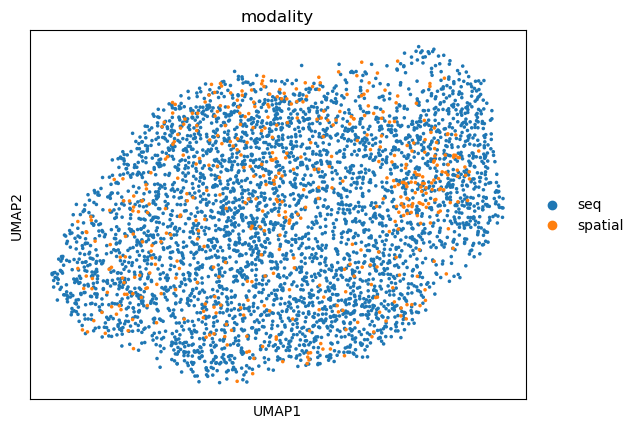

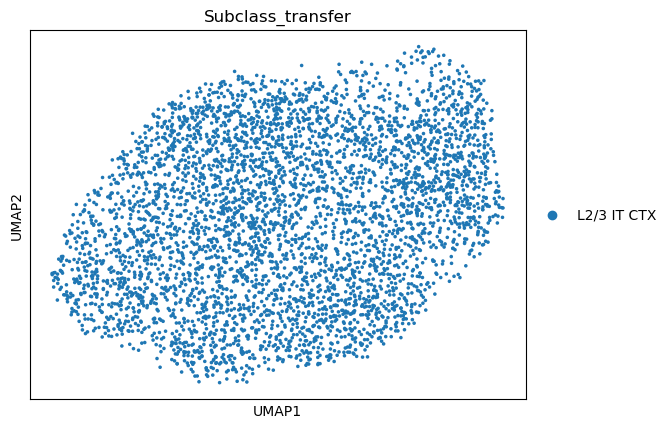

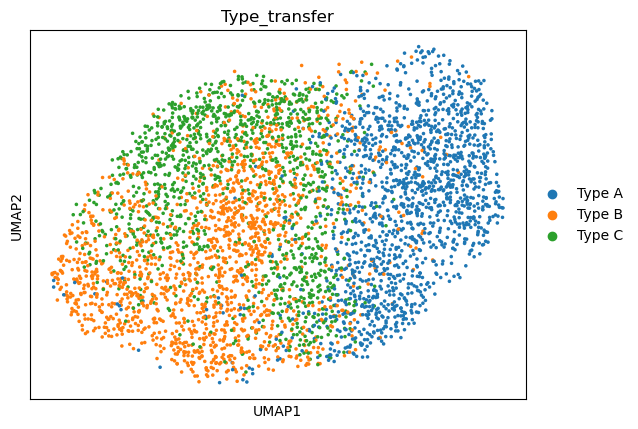

Integrating for partition p30


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 2975 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/4 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 119 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


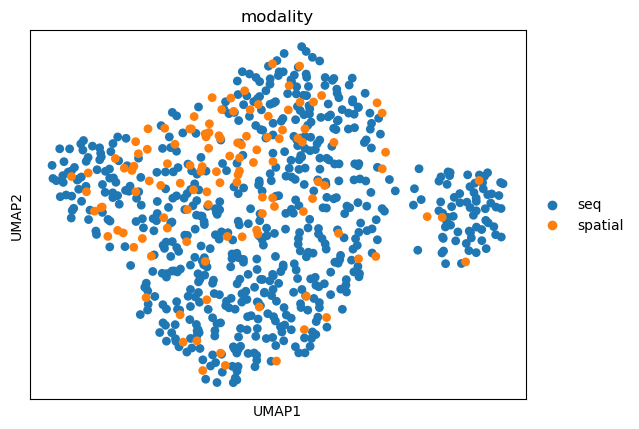

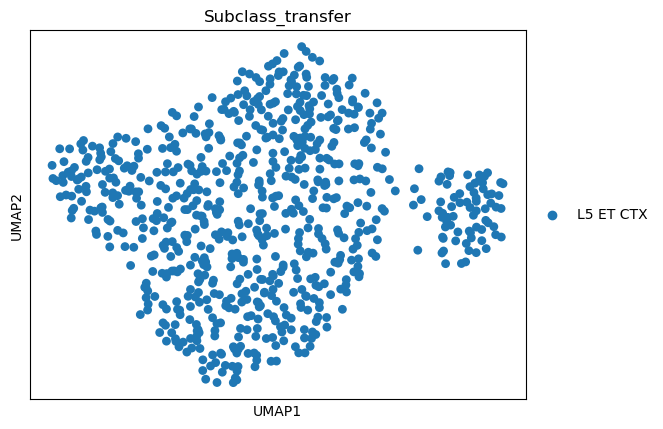

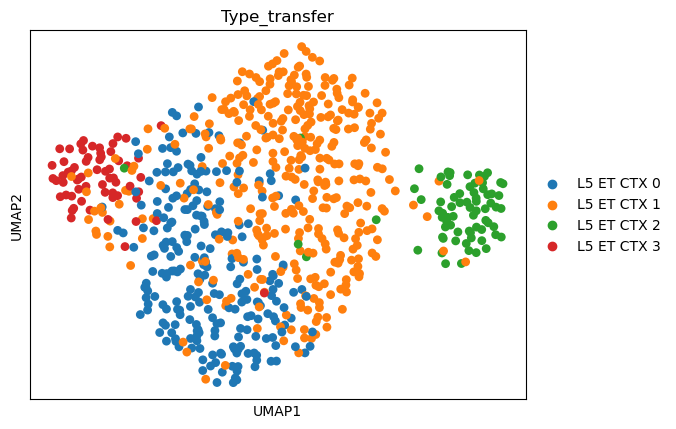

Integrating for partition p36


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 3625 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 145 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


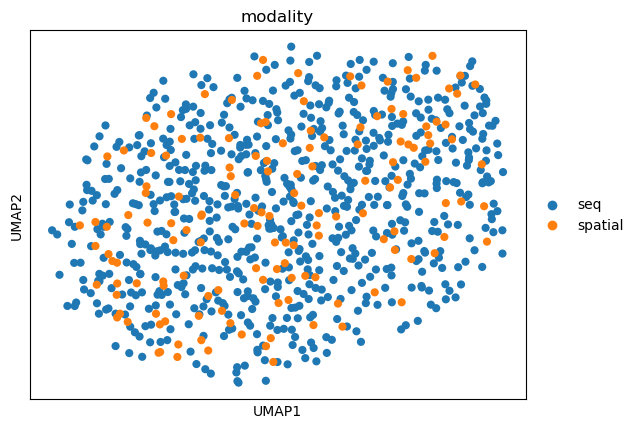

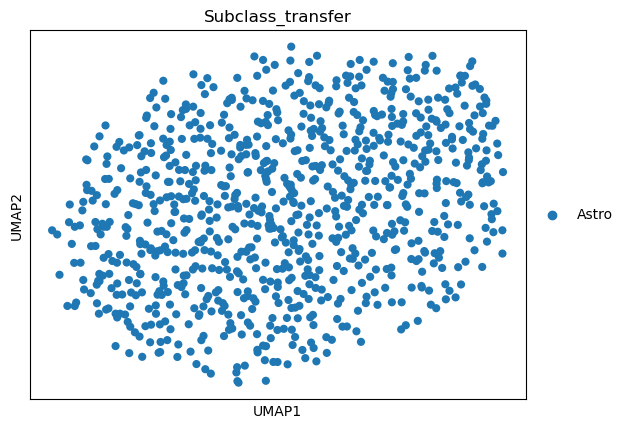

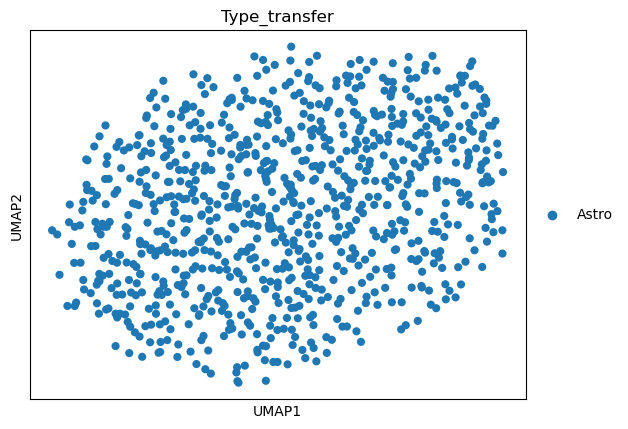

Integrating for partition p49


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 7350 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 294 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


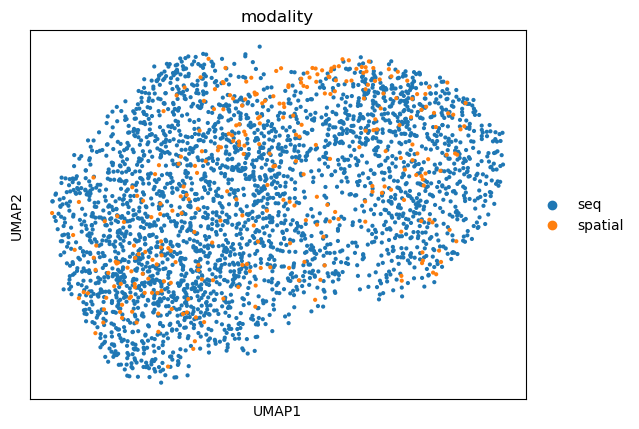

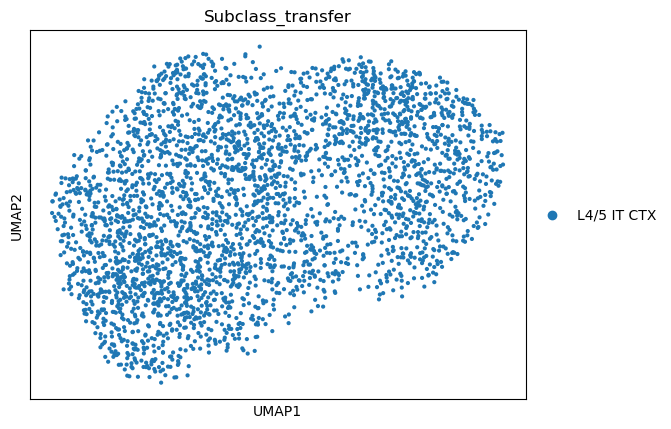

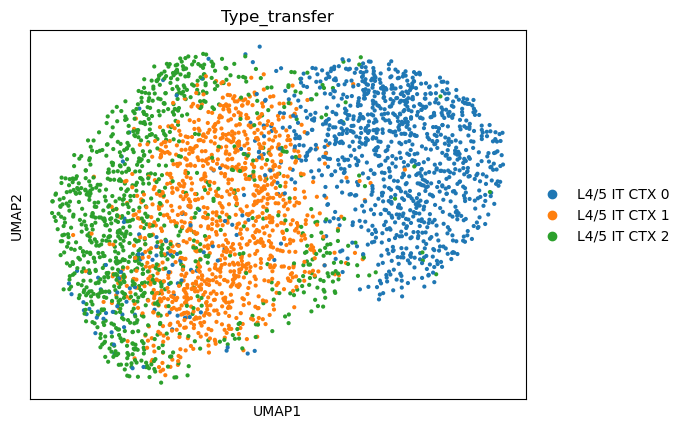

Integrating for partition p55


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=79
Score Anchors
Identified 2025 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 4/4 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 81 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


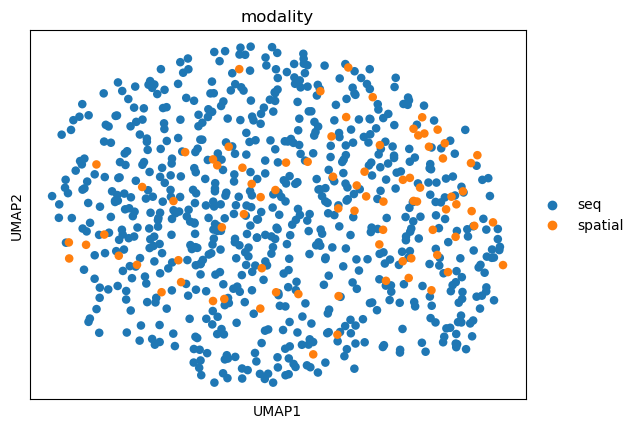

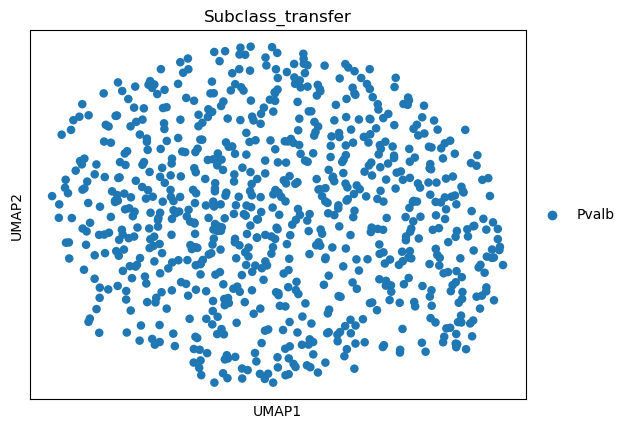

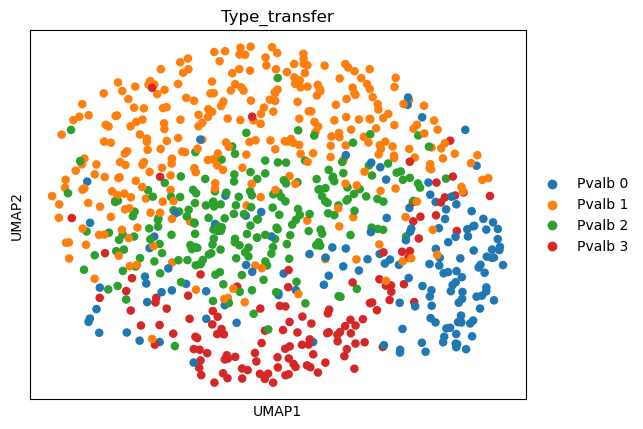

Integrating for partition p58


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 3650 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 146 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


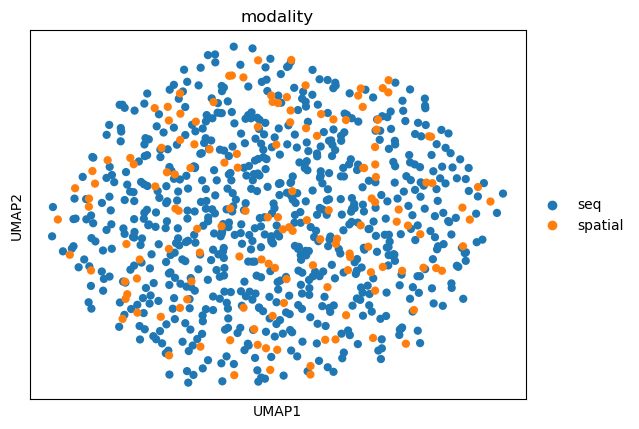

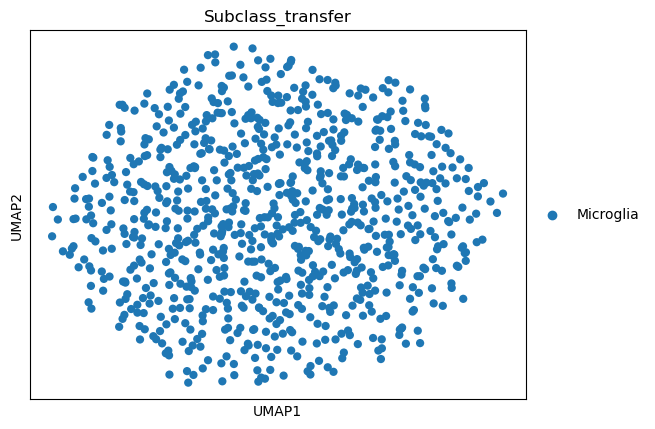

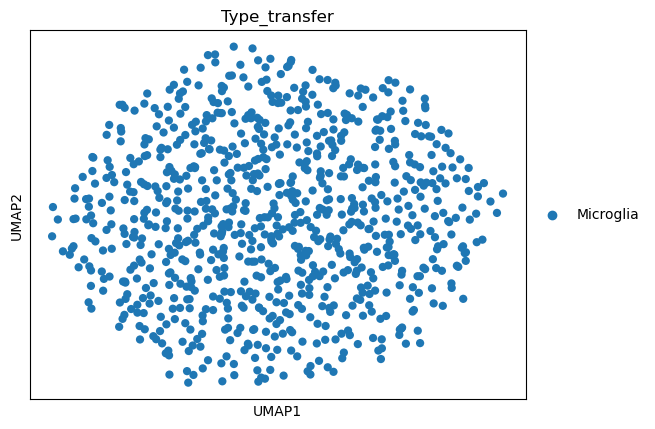

Integrating for partition p70


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=38
Score Anchors
Identified 1000 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 40 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


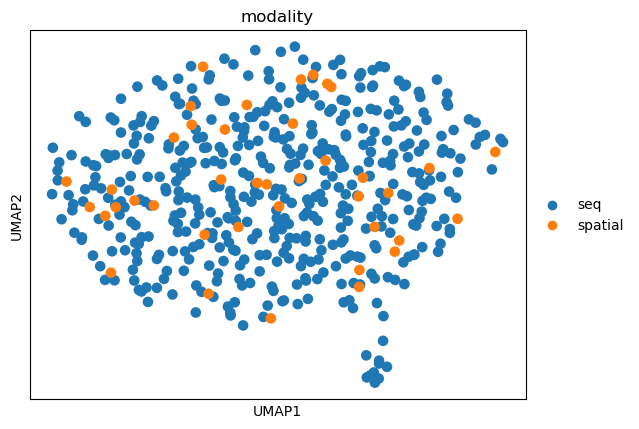

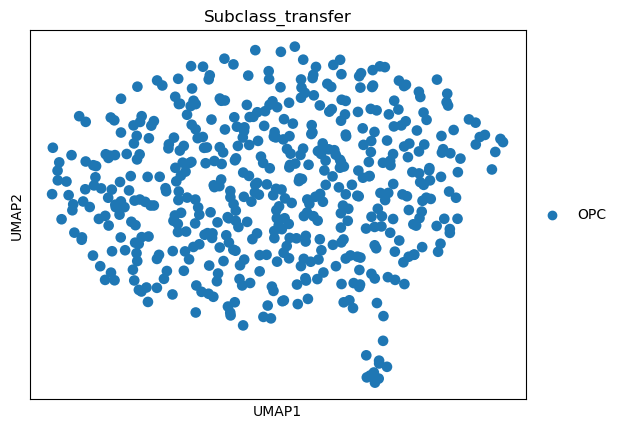

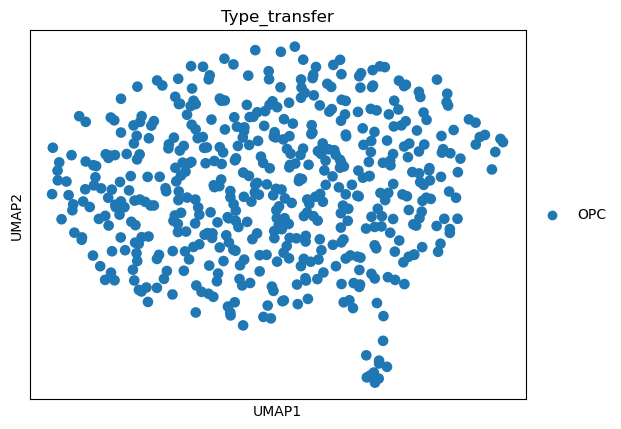

Integrating for partition p74


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=30
Score Anchors
Identified 800 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 1/1 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph
AnnData object with n_obs × n_vars = 32 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean'

/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


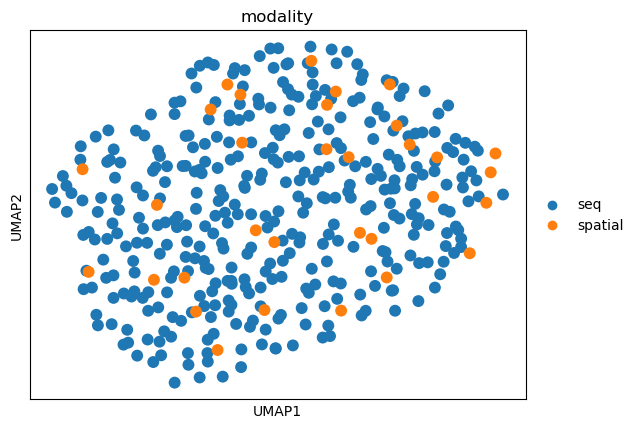

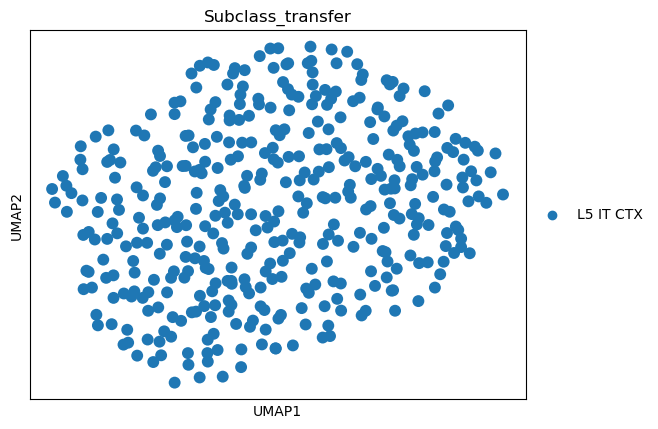

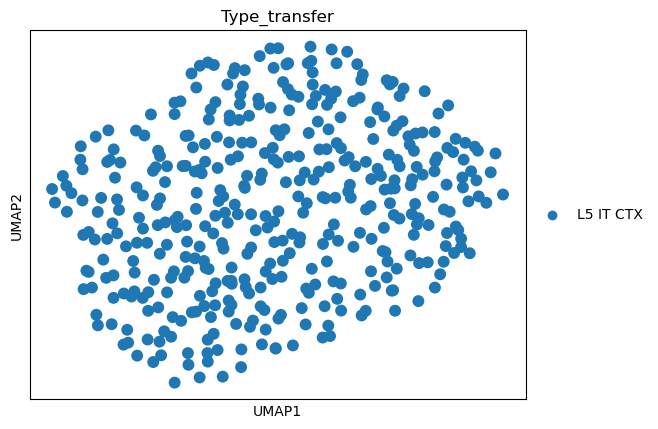

Integrating for partition p86


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 5600 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 224 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


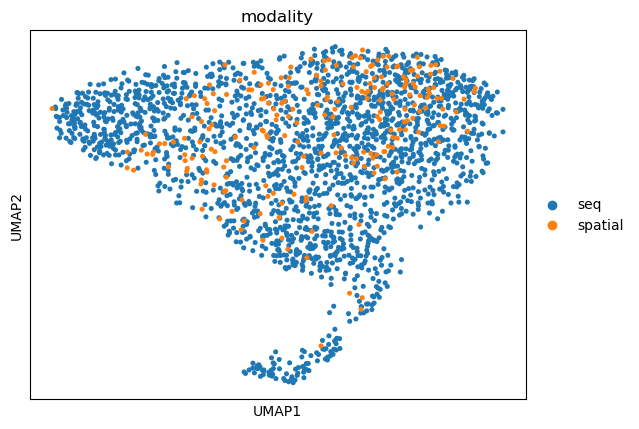

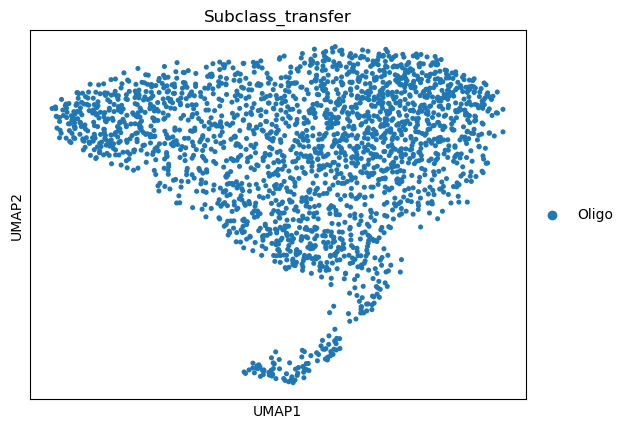

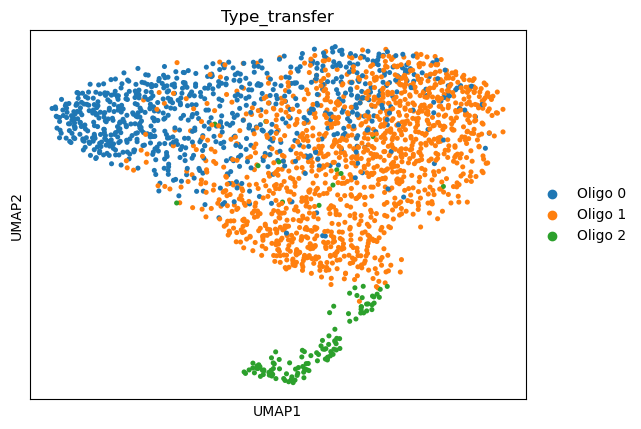

Integrating for partition p92


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=100
Score Anchors
Identified 4825 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 193 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


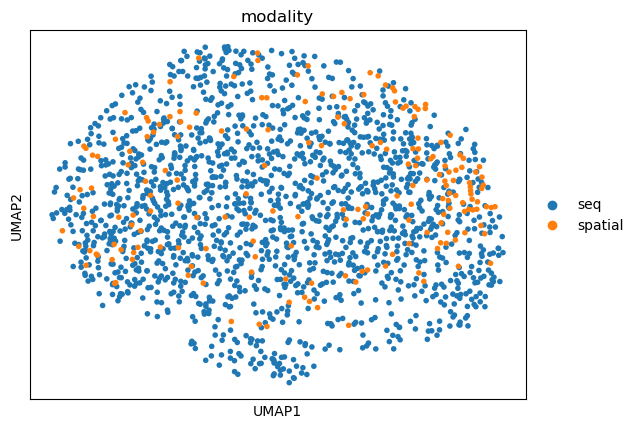

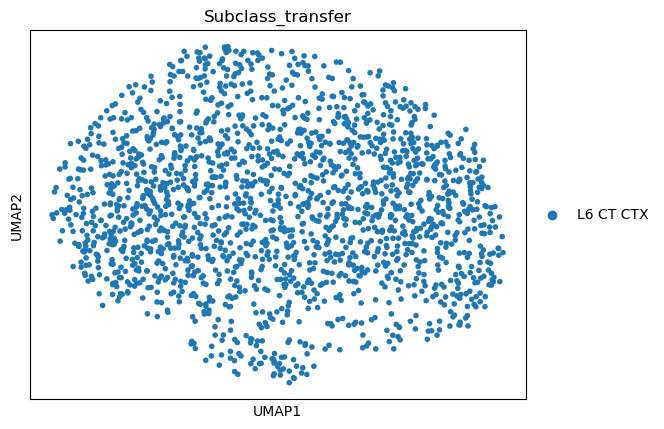

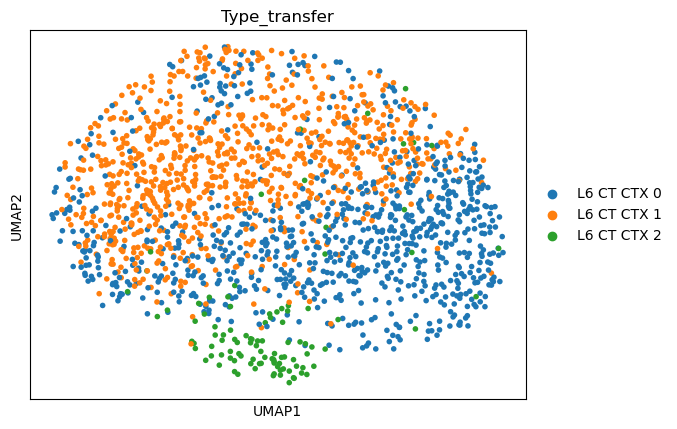

Integrating for partition p99


<timed exec>:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=84
Score Anchors
Identified 2150 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 2/2 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 86 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


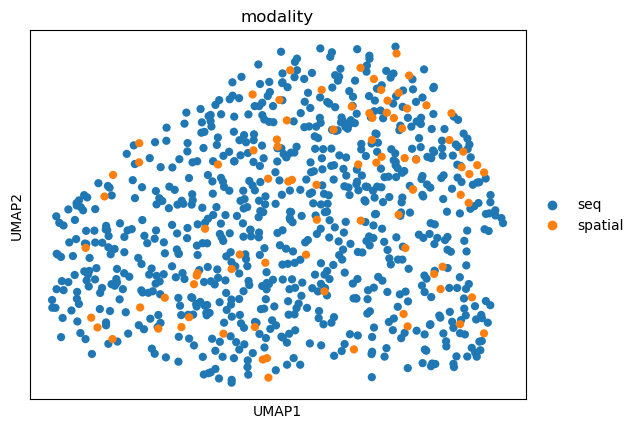

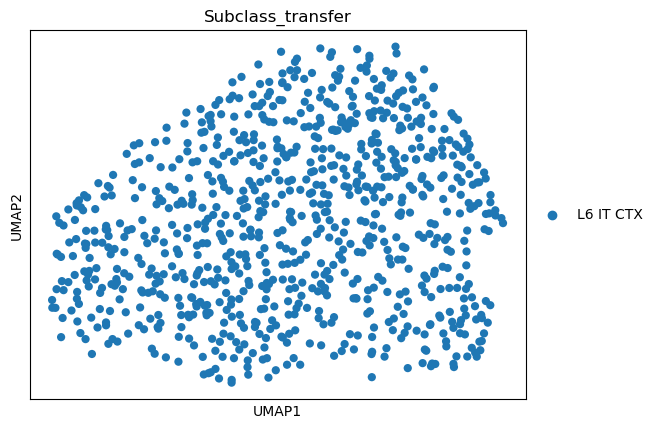

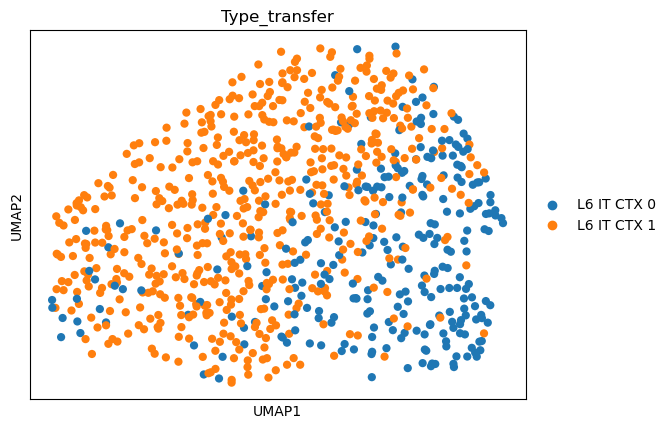

CPU times: user 29min 56s, sys: 1min 27s, total: 31min 23s
Wall time: 13min


In [32]:

%%time
# 设置工作目录
workspace_path = '/mnt/f/spatial/V2L/DR2_2/'
partition_path = workspace_path + 'partitions/'
partitions = sorted(os.listdir(partition_path))

for pn in partitions:
    print(f'Integrating for partition {pn}')
    
    # 设置每个分区的文件路径
    integration_path = partition_path + pn + '/'
    input_adata_seq_file = os.path.join(integration_path, 'adata_seq.h5ad')
    input_adata_spatial_file = os.path.join(integration_path, 'adata_spatial_integrated.h5ad')
    
    # 检查文件是否存在
    if not (os.path.exists(input_adata_seq_file) and os.path.exists(input_adata_spatial_file)):
        print(f'Missing input files for partition {pn}. Skipping this integration.')
        continue  # 如果文件缺失，跳过此分区
    ## Load and preprocess the data
    adata_seq_raw = sc.read_h5ad(input_adata_seq_file)
    adata_seq = adata_seq_raw.copy()
    adata_spatial_raw = sc.read_h5ad(input_adata_spatial_file)
    adata_spatial = adata_spatial_raw.copy()

    # Consider the common genes
    common_genes = np.array(adata_seq.var_names.intersection(adata_spatial.var_names))
    #adata_seq._inplace_subset_var(common_genes)
    
    # Normalize
    sc.pp.normalize_total(adata_seq, target_sum=1000)
    sc.pp.log1p(adata_seq)
    sc.pp.normalize_total(adata_spatial, target_sum=1000)
    sc.pp.log1p(adata_spatial)
    
    # Select variable genes
    #sc.pp.highly_variable_genes(adata_seq)
    #hv_genes = list(adata_seq.var.index[adata_seq.var['dispersions'] > 0])
    #adata_seq = adata_seq[:, adata_seq.var.index.isin(hv_genes)]
    #adata_spatial = adata_spatial[:, adata_spatial.var.index.isin(hv_genes)]
    #print(f'Use {len(hv_genes)} highly variable genes for integration.')
    
    # Scale the data
    sc.pp.scale(adata_seq)
    sc.pp.scale(adata_spatial)
    
    # Merge the datasets
    adata_merge = adata_seq.concatenate(adata_spatial,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None)
     # Select variable genes
    #sc.pp.highly_variable_genes(adata_merge)
    #target_genes=['Syt17','Stard8','Whrn','Rorb','Scnn1a','Syt2','Tle4','Syt6','Ccn2']
    #adata_merge.var['highly_variable'] = (
    #adata_merge.var['highly_variable'] | adata_merge.var_names.isin(target_genes))
    # PCA

    n_pcs = 30
    sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=n_pcs)
    
    adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
                  adata_merge[adata_merge.obs['modality'] == 'spatial']]
    
    ## Integration
    # Find the integration anchors
    integrator = SeuratIntegration()
    integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=25,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])
    
    # Label transfer
    cell_type_cols = ['Subclass', 'Type']
    transfer_results = integrator.label_transfer(
        ref=[0],
        qry=[1],
        categorical_key=cell_type_cols,
        key_dist='X_pca',
        k_weight=100,
        npc=n_pcs
    )
    integrator.save_transfer_results_to_adata(adata_merge, transfer_results)
    
    # Assign the transfered labels and the confidence
    for cell_type_col in cell_type_cols:
        adata_spatial_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
        adata_spatial_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)
        
        n_transfered = len(np.unique(adata_spatial_raw.obs[cell_type_col + '_transfer']))
        n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
        print(f'Transfered {n_transfered}/{n_total} {cell_type_col}.')
    
    # Impute gene expression
    X_imputed = impute_gene_expression(integrator, adata_list, adata_seq_raw.X, 
                                       ref=0, qry=1, npc=n_pcs, chunk_size=5000)
    adata_imputed = anndata.AnnData(X=X_imputed, obs=adata_spatial_raw.obs.copy(), 
                                var=adata_seq_raw.var.copy(), dtype=np.float32)
    print(adata_imputed)

    # 创建一个具有与 `adata_spatial_raw` 相同维度的矩阵，初始值为 0
    imputed_data = np.zeros(adata_spatial_raw.shape)

    # 匹配并填充 `imputed_data` 中的基因表达数据
    for i, gene in enumerate(adata_imputed.var_names):
        if gene in adata_spatial_raw.var_names:
           idx = adata_spatial_raw.var_names.get_loc(gene)
           imputed_data[:, idx] = adata_imputed[:, i].X.toarray().flatten()

    # 将填充后的矩阵存储在 `layers` 中
    adata_spatial_raw.layers['imputed'] = imputed_data
    # Save the label transfer results
    adata_spatial_raw.write_h5ad(os.path.join(integration_path, 'adata_spatial_label_transfer.h5ad'), 
                                 compression='gzip')
    # Create the imputation gene partition table
    gene_partition_df = adata_seq_raw.var.copy()
    gene_partition_df.index.name = 'gene'
    gene_partition_df['gene_partition'] = np.arange(gene_partition_df.shape[0], dtype=int) // 1000
    gene_partition_df.to_csv(os.path.join(integration_path,f'/mnt/f/spatial/V2L/DR2_2/partitions/{pn}/gene_partition.csv'))
    
    gene_partitions = np.unique(gene_partition_df['gene_partition'])

    
    ## Co-embedding
    # Correct the PCs using the integration anchors
    corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

    adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)
    
    # Calculate KNN using the integrated PCs
    sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')
    
    if len(np.unique(adata_merge.obs['Subclass_transfer'])) > 1:
        # Generate the PAGA plot for the initial arrangement of the UMAP
        sc.tl.paga(adata_merge, groups='Subclass_transfer')
        sc.pl.paga(adata_merge, save=f'{pn}_paga.png', cmap='gist_ncar')
    
        sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
    else:
        sc.tl.umap(adata_merge, min_dist=0.5)
        
    # Save the umap
    sc.pl.umap(adata_merge, color='modality', save=f'{pn}_umap_modality.png')
    sc.pl.umap(adata_merge, color='Subclass_transfer', save=f'{pn}_umap_subclass.png' )
    sc.pl.umap(adata_merge, color='Type_transfer', save=f'{pn}_umap_type.png')

    # 保存合并后的数据
    adata_merge.write_h5ad(os.path.join(integration_path, 'adata_merged_round2.h5ad'), compression='gzip')

Integrating for partition p24


<timed exec>:45: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/root/anaconda3/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


Find anchors across datasets.
Run CCA
non zero dims 20
Find Anchors using k=100
Score Anchors
Identified 6531 anchors between datasets 0 and 1.
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
Transfered 1/1 Subclass.
Transfered 3/3 Type.
Initialize
Find nearest anchors. k_weight:  30
Normalize graph


/root/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 436 × 21834
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data


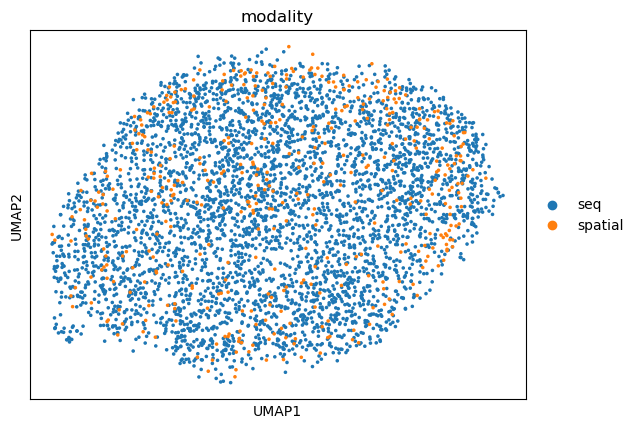

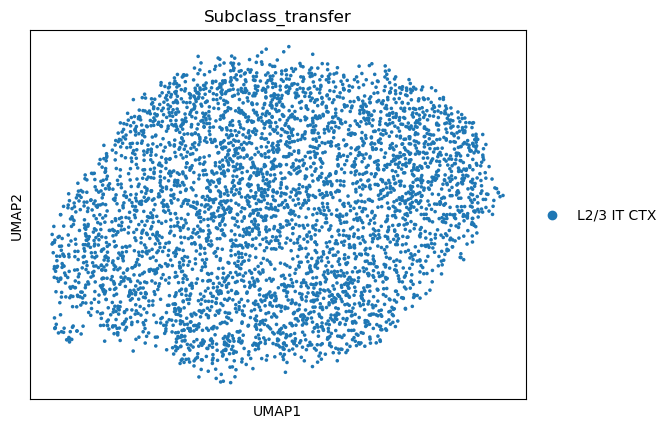

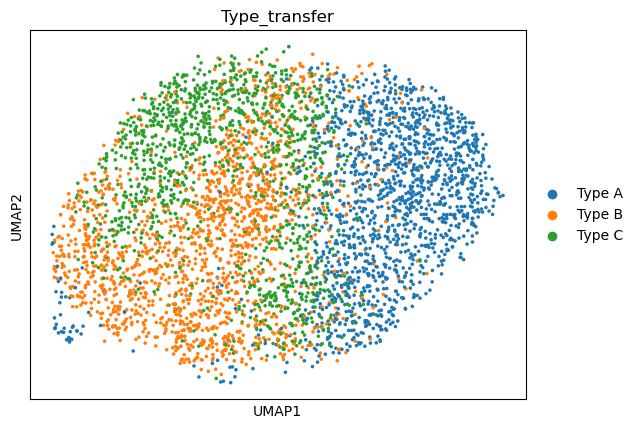

CPU times: user 5min 1s, sys: 15.2 s, total: 5min 16s
Wall time: 2min 14s


In [393]:

%%time
# 设置工作目录
workspace_path = '/mnt/f/spatial/V2L/DR2_2/'
partition_path = workspace_path + 'partitions/'
partitions = ['p24']
for pn in partitions:
    print(f'Integrating for partition {pn}')
    
    # 设置每个分区的文件路径
    integration_path = partition_path + pn + '/'
    input_adata_seq_file = os.path.join(integration_path, 'adata_seq.h5ad')
    input_adata_spatial_file = os.path.join(integration_path, 'adata_spatial_integrated.h5ad')
    
    # 检查文件是否存在
    if not (os.path.exists(input_adata_seq_file) and os.path.exists(input_adata_spatial_file)):
        print(f'Missing input files for partition {pn}. Skipping this integration.')
        continue  # 如果文件缺失，跳过此分区
    ## Load and preprocess the data
    adata_seq_raw = sc.read_h5ad(input_adata_seq_file)
    adata_seq = adata_seq_raw.copy()
    adata_spatial_raw = sc.read_h5ad(input_adata_spatial_file)
    adata_spatial = adata_spatial_raw.copy()

    # Consider the common genes
    common_genes = np.array(adata_seq.var_names.intersection(adata_spatial.var_names))
    #adata_seq._inplace_subset_var(common_genes)
    
    # Normalize
    sc.pp.normalize_total(adata_seq, target_sum=1000)
    sc.pp.log1p(adata_seq)
    sc.pp.normalize_total(adata_spatial, target_sum=1000)
    sc.pp.log1p(adata_spatial)
    
    # Select variable genes
    #sc.pp.highly_variable_genes(adata_seq)
    #hv_genes = list(adata_seq.var.index[adata_seq.var['dispersions'] > 0])
    #adata_seq = adata_seq[:, adata_seq.var.index.isin(hv_genes)]
    #adata_spatial = adata_spatial[:, adata_spatial.var.index.isin(hv_genes)]
    #print(f'Use {len(hv_genes)} highly variable genes for integration.')
    
    # Scale the data
    sc.pp.scale(adata_seq)
    sc.pp.scale(adata_spatial)
    
    # Merge the datasets
    adata_merge = adata_seq.concatenate(adata_spatial,
                                    batch_categories=['seq', 'spatial'],
                                    batch_key='modality',
                                    index_unique=None)
     # Select variable genes
    #sc.pp.highly_variable_genes(adata_merge)
    #target_genes=['Syt17','Stard8','Whrn','Rorb','Scnn1a','Syt2','Tle4','Syt6','Ccn2']
    #adata_merge.var['highly_variable'] = (
    #adata_merge.var['highly_variable'] | adata_merge.var_names.isin(target_genes))
    # PCA

    n_pcs = 20
    sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=n_pcs)
    
    adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
                  adata_merge[adata_merge.obs['modality'] == 'spatial']]
    
    ## Integration
    # Find the integration anchors
    integrator = SeuratIntegration()
    integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=15,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=100,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])
    
    # Label transfer
    cell_type_cols = ['Subclass', 'Type']
    transfer_results = integrator.label_transfer(
        ref=[0],
        qry=[1],
        categorical_key=cell_type_cols,
        key_dist='X_pca',
        k_weight=100,
        npc=n_pcs
    )
    integrator.save_transfer_results_to_adata(adata_merge, transfer_results)
    
    # Assign the transfered labels and the confidence
    for cell_type_col in cell_type_cols:
        adata_spatial_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
        adata_spatial_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)
        
        n_transfered = len(np.unique(adata_spatial_raw.obs[cell_type_col + '_transfer']))
        n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
        print(f'Transfered {n_transfered}/{n_total} {cell_type_col}.')
    
    # Impute gene expression
    X_imputed = impute_gene_expression(integrator, adata_list, adata_seq_raw.X, 
                                       ref=0, qry=1, npc=n_pcs, chunk_size=5000)
    adata_imputed = anndata.AnnData(X=X_imputed, obs=adata_spatial_raw.obs.copy(), 
                                var=adata_seq_raw.var.copy(), dtype=np.float32)
    print(adata_imputed)

    # 创建一个具有与 `adata_spatial_raw` 相同维度的矩阵，初始值为 0
    imputed_data = np.zeros(adata_spatial_raw.shape)

    # 匹配并填充 `imputed_data` 中的基因表达数据
    for i, gene in enumerate(adata_imputed.var_names):
        if gene in adata_spatial_raw.var_names:
           idx = adata_spatial_raw.var_names.get_loc(gene)
           imputed_data[:, idx] = adata_imputed[:, i].X.toarray().flatten()

    # 将填充后的矩阵存储在 `layers` 中
    adata_spatial_raw.layers['imputed'] = imputed_data
    # Save the label transfer results
    adata_spatial_raw.write_h5ad(os.path.join(integration_path, 'adata_spatial_label_transfer.h5ad'), 
                                 compression='gzip')
    # Create the imputation gene partition table
    gene_partition_df = adata_seq_raw.var.copy()
    gene_partition_df.index.name = 'gene'
    gene_partition_df['gene_partition'] = np.arange(gene_partition_df.shape[0], dtype=int) // 1000
    gene_partition_df.to_csv(os.path.join(integration_path,f'/mnt/f/spatial/V2L/DR2_2/partitions/{pn}/gene_partition.csv'))
    
    gene_partitions = np.unique(gene_partition_df['gene_partition'])

    
    ## Co-embedding
    # Correct the PCs using the integration anchors
    corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

    adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)
    
    # Calculate KNN using the integrated PCs
    sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')
    
    if len(np.unique(adata_merge.obs['Subclass_transfer'])) > 1:
        # Generate the PAGA plot for the initial arrangement of the UMAP
        sc.tl.paga(adata_merge, groups='Subclass_transfer')
        sc.pl.paga(adata_merge, save=f'{pn}_paga.png', cmap='gist_ncar')
    
        sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
    else:
        sc.tl.umap(adata_merge, min_dist=0.5)
        
    # Save the umap
    sc.pl.umap(adata_merge, color='modality', save=f'{pn}_umap_modality.png')
    sc.pl.umap(adata_merge, color='Subclass_transfer', save=f'{pn}_umap_subclass.png' )
    sc.pl.umap(adata_merge, color='Type_transfer', save=f'{pn}_umap_type.png')

    # 保存合并后的数据
    adata_merge.write_h5ad(os.path.join(integration_path, 'adata_merged_round2.h5ad'), compression='gzip')

In [ ]:
p24, 4067, ['L2/3 IT CTX']
p30, 628, ['L5 ET CTX']
p36, 724, ['Astro']
p49, 3021, ['L4/5 IT CTX']
p55, 710, ['Pvalb']
p58, 705, ['Microglia']
p61, 234, ['L5 NP CTX']
p63, 493, ['Sst']
p64, 156, ['L6b CTX']
p67, 382, ['Lamp5']
p70, 472, ['OPC']
p72, 383, ['Vip']
p73, 109, ['ABC', 'Sncg', 'VLMC']
p74, 377, ['L5 IT CTX']
p86, 2027, ['Oligo']
p92, 1652, ['L6 CT CTX']
p99, 769, ['L6 IT CTX']

In [33]:
import scipy.sparse
import scipy.spatial

def get_cluster_mean_expression_matrix(adata, cluster_column):
    '''Get a dataframe of mean gene expression of each cluster.'''
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
   
    cell_exp_mtx = pd.DataFrame(X, index=adata.obs[cluster_column], columns=adata.var.index)    
    return cell_exp_mtx.groupby(by=cluster_column).mean()


def calc_cell_cosines_to_cluster_mean_exps(adata, cluster_col, cluster_mean_exp_df):
    cluster_mean_exp_df = cluster_mean_exp_df.loc[:, adata.var.index]
    cluster_id_map = {cluster_mean_exp_df.index[i]:i for i in range(cluster_mean_exp_df.shape[0])}
    cell_cluster_ids = np.array(adata.obs[cluster_col].map(cluster_id_map))
    
    X_cluster_mean = cluster_mean_exp_df.values[cell_cluster_ids]
    
    if scipy.sparse.issparse(adata.X):
        X = adata.X.toarray()
    else:
        X = adata.X
    
    cosines = []
    for i in range(adata.shape[0]):
        if np.sum(X[i]) > 0:
            cosines.append(1 - scipy.spatial.distance.cosine(X[i], X_cluster_mean[i]))
        else:
            cosines.append(0)
    
    return cosines

In [34]:
# Combine the label transfer results

partition_path = '/mnt/f/spatial/V2L/DR2_2/partitions'
partitions = sorted(os.listdir(partition_path))
adatas = []
for pn in partitions:
    adata_file = os.path.join(partition_path, pn, 'adata_spatial_label_transfer.h5ad')
    adatas.append(sc.read_h5ad(adata_file))
    
adata = anndata.concat(adatas)
adata.write_h5ad('/mnt/f/spatial/V2L/DR2_2/spatial_transfer_20.h5ad')

In [35]:
# Combine the merged data
partition_path = '/mnt/f/spatial/V2L/DR2_2/partitions'
partitions = sorted(os.listdir(partition_path))
adatas = []
for pn in partitions:
    adata_file = os.path.join(partition_path, pn, 'adata_merged_round2.h5ad')
    adatas.append(sc.read_h5ad(adata_file))
    
adata_merged2 = anndata.concat(adatas)
adata_merged2.write_h5ad('/mnt/f/spatial/V2L/DR2_2/spatial_merged_round2_20.h5ad')

In [4]:
adata=sc.read_h5ad('F:/spatial/V2L/DR2_2/spatial_tranfer_17.h5ad')

In [107]:
adata

AnnData object with n_obs × n_vars = 1172 × 25556
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'area', 'coor_x', 'coor_y', 'areaL1', 'coor_x_ad', 'coor_y_ad', 'left_right', 'areaL2', 'ident', 'integration_partition_transfer', 'integration_partition_confidence', 'Subclass_transfer', 'Subclass_confidence', 'Type_transfer', 'Type_confidence'
    obsm: 'stereo'
    layers: 'imputed'

In [36]:
all_spatial = pd.read_csv('/mnt/f/spatial/V1_integration/cortex/DR2_2_cortex.csv',index_col='cell_id')

In [37]:
adata_density = adata.obs

In [38]:
all_spatial_index = all_spatial.index.astype(str)

In [39]:
adata_index =adata_density.index.astype(str)

In [40]:
common_index  =all_spatial_index.intersection(adata_index)

In [41]:
common_index =common_index.astype(str)

In [42]:
all_spatial.index = all_spatial.index.astype(str)

In [43]:
spatial_common = all_spatial.loc[all_spatial.index.intersection(common_index)]

In [44]:
adata.obs['digital_layer']=spatial_common['digital_layer']

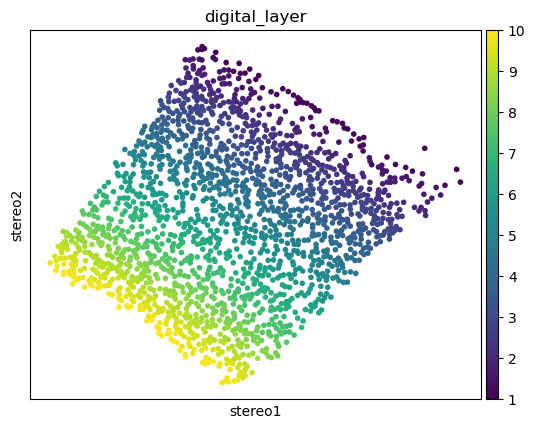

In [45]:
sc.pl.embedding(adata, basis='stereo',color='digital_layer',alpha=None)

In [46]:
adata.write_h5ad('/mnt/f/spatial/V2L/DR2_2/spatial_transfer_digital_layer_20.h5ad')

In [409]:
adata.obs['Type_transfer']

6832          Type A
6833          Type B
6834          Type A
6838          Type A
6840          Type A
            ...     
17832    L6 IT CTX 1
17834    L6 IT CTX 1
17841    L6 IT CTX 1
17848    L6 IT CTX 1
17853    L6 IT CTX 1
Name: Type_transfer, Length: 1906, dtype: category
Categories (31, object): ['Astro', 'L4/5 IT CTX 0', 'L4/5 IT CTX 1', 'L4/5 IT CTX 2', ..., 'Type B', 'Type C', 'Vip 0', 'Vip 1']

In [410]:
adata_it =adata[adata.obs['Subclass_transfer']!='Astro'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Microglia'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='OPC'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Oligo'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Pvalb'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Sst'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Vip'] 
adata_it =adata_it[adata_it.obs['Subclass_transfer']!='Lamp5'] 

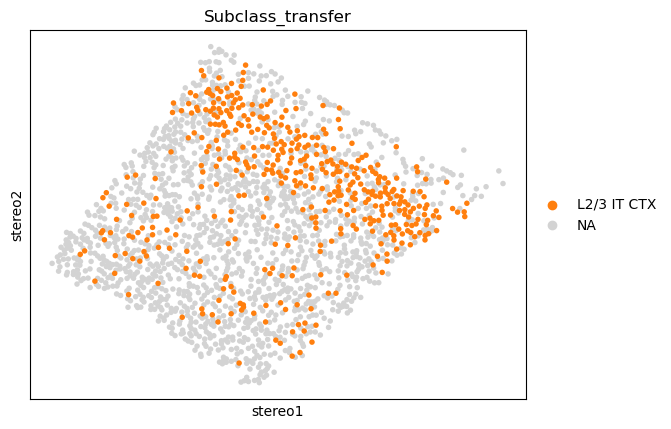

In [411]:
sc.pl.embedding(adata,basis='stereo',color=['Subclass_transfer'],groups=['L2/3 IT CTX'])

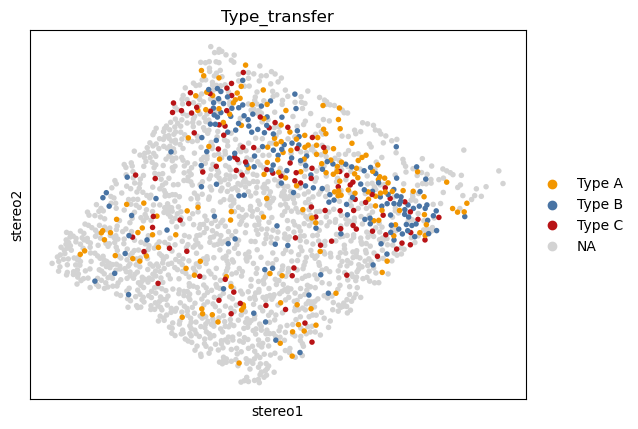

In [412]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['Type A','Type B','Type C'],palette=["#4974a4","#b81316","#f29600"])

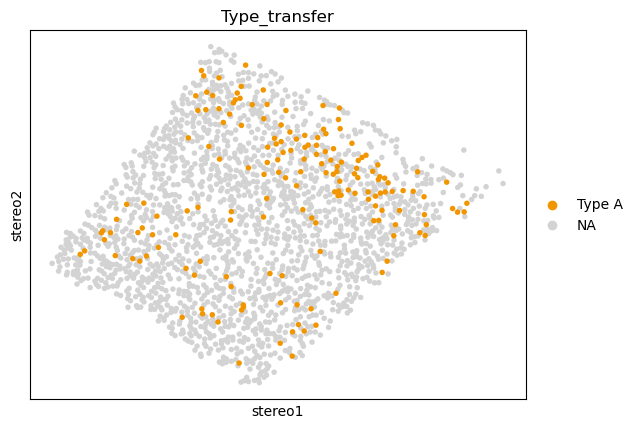

In [413]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['Type A'])

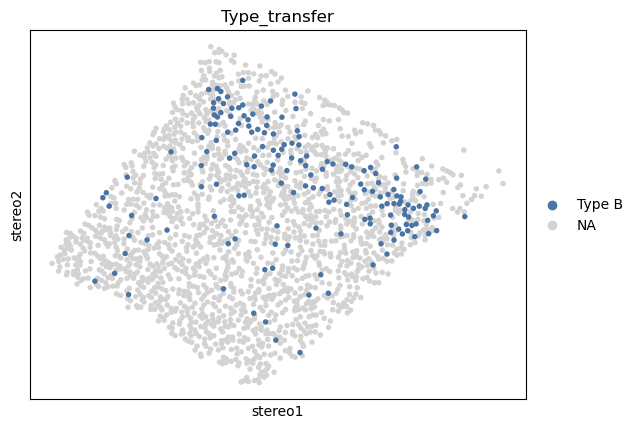

In [414]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['Type B'])

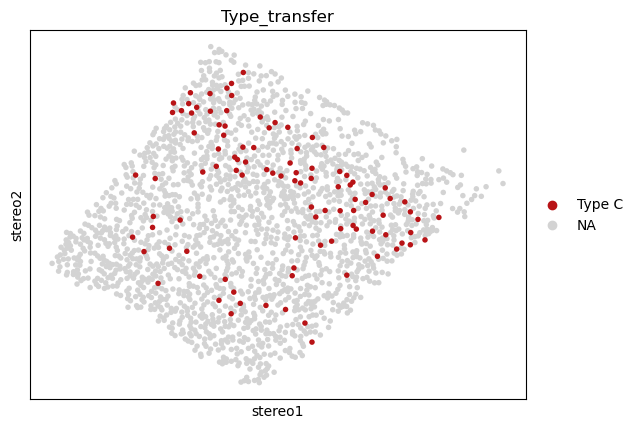

In [415]:
sc.pl.embedding(adata,basis='stereo',color=['Type_transfer'],groups=['Type C'])

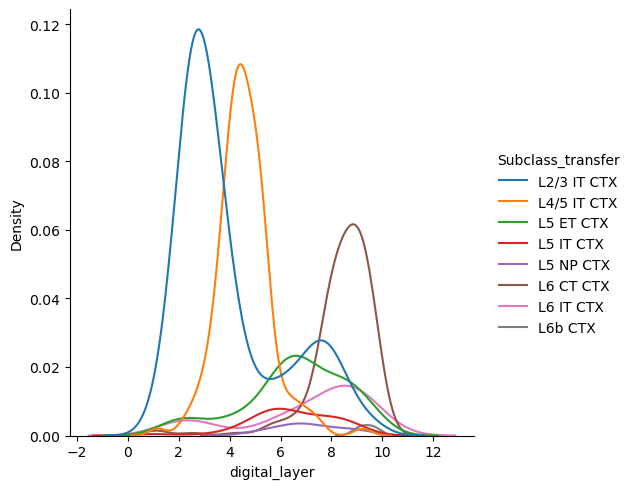

In [416]:
sns.displot(data=adata_it.obs, x='digital_layer',hue="Subclass_transfer",kind='kde')

In [417]:
adata_l23 = adata[adata.obs['Subclass_transfer']=='L2/3 IT CTX']

(0.0, 5.5)

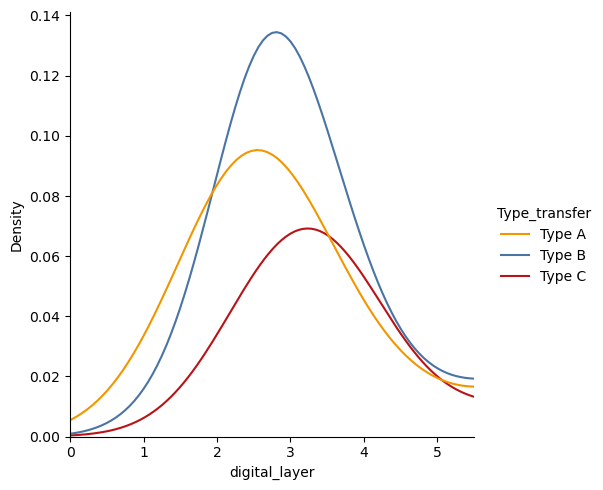

In [418]:
sns.displot(data=adata_l23.obs, x="digital_layer",hue="Type_transfer",kind='kde',palette=["#f29600","#4974a4","#b81316"])


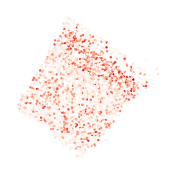

In [419]:
# 确定目标基因
target_gene = 'Syt17'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

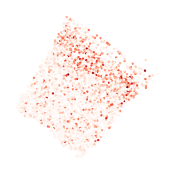

In [420]:
# 确定目标基因
target_gene = 'Stard8'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

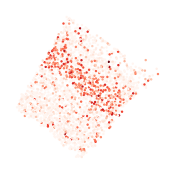

In [421]:
# 确定目标基因
target_gene = 'Whrn'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

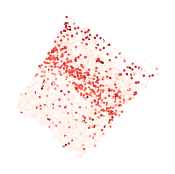

In [422]:
# 确定目标基因
target_gene = 'Rorb'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

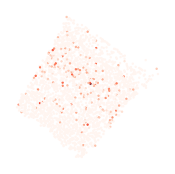

In [423]:
# 确定目标基因
target_gene = 'Scnn1a'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

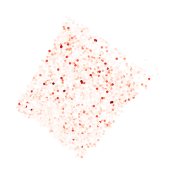

In [424]:
# 确定目标基因
target_gene = 'Syt2'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

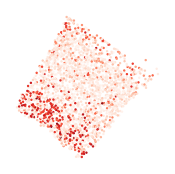

In [425]:
# 确定目标基因
target_gene = 'Tle4'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

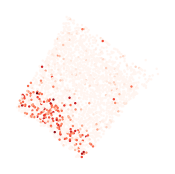

In [426]:
# 确定目标基因
target_gene = 'Syt6'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

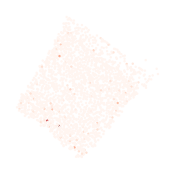

In [427]:
# 确定目标基因
target_gene = 'Cplx3'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

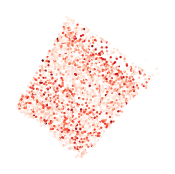

In [428]:
# 确定目标基因
target_gene = 'Cdh13'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

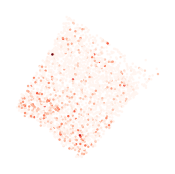

In [429]:
# 确定目标基因
target_gene = 'Igfbp4'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")

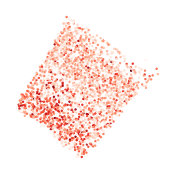

In [430]:
# 确定目标基因
target_gene = 'Etv5'  # 替换为感兴趣的基因

# 确保目标基因存在于数据中
if target_gene in adata.var_names:
    # 获取坐标信息
    x = adata.obs['coor_x_ad']
    y = adata.obs['coor_y_ad']

    # 获取并标准化该基因的表达数据（Z-score）
    gene_expression = adata[:, target_gene].layers['imputed'].toarray().flatten()
    gene_expression_zscore = zscore(gene_expression)
    # 使用 Min-Max 归一化将 Z-score 数据缩放到 0 到 1 之间
    gene_expression_normalized = (gene_expression_zscore - gene_expression_zscore.min()) / (gene_expression_zscore.max() - gene_expression_zscore.min())
    # 创建散点图
    plt.figure(figsize=(2, 2))
    plt.scatter(x, y, c=gene_expression_normalized, cmap='Reds', s=0.5)
    #plt.colorbar(label= 'Expression (Z-score)')
    # 去掉坐标轴
    plt.axis('off')
    plt.show()
else:
    print(f"{target_gene} 不存在于数据中，请检查基因名称。")